# 03 Experiments with pre-defined splits

One of the benefits of the disjoint generative models approach, is the ability to use different models for different subsets of the data. For example using a model that is good for nummerical attributes to model those variables, and using a model that is good for categorical attributes on categorical attributes, etc.

In the following we will show how this can be done to the benefit of the synthetic data quality. 

The example will be based on the Hepatitis dataset from the UCI repository. The dataset contains ~1300 rows and 29 columns. The columns are a mix of categorical and numerical attributes. The dataset contains no missing values. We report the average metric result and standard error of the mean for 10 repeated rund of the experiment with 80% of the data used for training and 20% for the metrics that require holdout data.

In [2]:
### Imports
import pandas as pd

from pandas import DataFrame
from typing import List, Dict

from joblib import Parallel, delayed

from syntheval import SynthEval

from sklearn.ensemble import RandomForestClassifier
from disjoint_generative_model import DisjointGenerativeModels
from disjoint_generative_model.utils.joining_validator import JoiningValidator
from disjoint_generative_model.utils.joining_strategies import UsingJoiningValidator
from disjoint_generative_model.utils.generative_model_adapters import generate_synthetic_data

### Constants
NUM_REPS = 10

### Metrics
metrics = {
    "pca"       : {},
    "h_dist"    : {},
    "corr_diff" : {"mixed_corr": True},
    "auroc_diff" : {"model": "rf_cls"},
    "cls_acc"   : {"F1_type": "macro"},
    "eps_risk"  : {},
    "dcr"       : {},
    "mia"  : {"num_eval_iter": 5},
}

In [3]:
### Load training and testing datasets and define categorical and numerical attributes

df_train = pd.read_csv('experiments/datasets/hepatitis_train.csv')
df_test = pd.read_csv('experiments/datasets/hepatitis_test.csv')

label = 'b_class'

cat_atts = df_train.select_dtypes(include='object').columns.tolist()

for att in [att for att in df_train.columns if att not in cat_atts]:
    if len(df_train[att].unique()) <= 5:
        cat_atts.append(att)

num_atts = [att for att in df_train.columns if att not in cat_atts]

print(cat_atts)
print(num_atts)

df_train.head()

['WBC', 'RBC', 'Plat', 'RNA Base', 'RNA 4', 'RNA 12', 'RNA EOT', 'RNA EF', 'Gender', 'Fever', 'Nausea/Vomting', 'Headache', 'Diarrhea', 'Fatigue & generalized bone ache', 'Jaundice', 'Epigastric pain', 'b_class']
['Age', 'BMI', 'HGB', 'AST 1', 'ALT 1', 'ALT 4', 'ALT 12', 'ALT 24', 'ALT 36', 'ALT 48', 'ALT after 24 w', 'Baseline histological Grading']


,Age,Gender,BMI,Fever,Nausea/Vomting,Headache,Diarrhea,Fatigue & generalized bone ache,Jaundice,Epigastric pain,...,ALT 36,ALT 48,ALT after 24 w,RNA Base,RNA 4,RNA 12,RNA EOT,RNA EF,Baseline histological Grading,b_class
0,47,2,32,2,2,1,2,2,2,2,...,87,56,39,"(5, 1201086]","(5, 1201715]","(5, 3731527]","(5, 808450]","(5, 808450]",11,1
1,36,2,24,2,1,2,2,2,1,2,...,108,74,45,"(5, 1201086]","(5, 1201715]","(5, 3731527]","(5, 808450]","(5, 808450]",3,1
2,50,1,34,1,1,2,1,2,2,2,...,71,125,28,"(5, 1201086]","(5, 1201715]","(5, 3731527]","(5, 808450]","(5, 808450]",9,1
3,32,2,30,1,2,1,2,2,1,1,...,102,84,40,"(5, 1201086]","(5, 1201715]","(5, 3731527]","(5, 808450]","(5, 808450]",6,0
4,58,1,29,2,2,1,1,2,2,1,...,55,40,40,"(5, 1201086]","(5, 1201715]","(0, 5]","(0, 5]","(0, 5]",15,1


In [3]:
### Background measurement
SE = SynthEval(df_train, df_test, verbose=False)
SE.evaluate(df_train, analysis_target_var=label,**metrics)

,metric,dim,val,err,n_val,n_err
0,pca_eigval_diff,u,0.000000e+00,NaN,1.000000,NaN
1,pca_eigvec_ang,u,3.420361e-08,NaN,1.000000,NaN
2,avg_h_dist,u,0.000000e+00,0.000000,1.000000,0.000000
3,corr_mat_diff,u,0.000000e+00,NaN,1.000000,NaN
4,auroc,u,0.000000e+00,NaN,0.761594,NaN
5,avg_F1_diff,u,0.000000e+00,0.008192,1.000000,0.008192
6,avg_F1_diff_hout,u,0.000000e+00,0.000000,1.000000,0.000000
7,eps_identif_risk,p,0.000000e+00,NaN,1.000000,NaN
8,priv_loss_eps,p,-2.090498e-01,NaN,0.790950,NaN
9,median_DCR,p,1.000000e+00,NaN,0.761594,NaN


In [4]:
def model_experiment(df_train: DataFrame, df_test: DataFrame, label: str, model: str, metrics: Dict[str, dict]) -> DataFrame:
    """ Function to do repeated runs of a generative model on the same 
    dataset and return best estimate of the mean of the various metrics. 
    """
    SE = SynthEval(df_train, df_test, verbose=False)

    dfs_list = Parallel(n_jobs=-1)(delayed(generate_synthetic_data)(df_train, model, id=i) for i in range(NUM_REPS))
    dfs = {f"rep_{i}": df_synth for i, df_synth in enumerate(dfs_list)}
    
    res, _ = SE.benchmark(dfs, analysis_target_var=label,**metrics, rank_strategy='summation')
    
    res = res.drop(columns=[col for col in res.columns if 'error' in col])
    res = res.drop(columns=['rank', 'u_rank', 'p_rank', 'f_rank'])
    res = res.droplevel(1, axis=1)

    mean_values = res.mean()
    sem_error = res.sem()
    results = pd.concat([mean_values, sem_error], axis=1, keys=['mean', 'sem'])

    return results

In [ ]:
cart_results = model_experiment(df_train, df_test, label, 'synthpop', metrics)
cart_results.to_csv('experiments/results/hepatitis_case_study_adapt/synthpop.csv')

In [ ]:
bn_results = model_experiment(df_train, df_test, label, 'datasynthesizer', metrics)
bn_results.to_csv('experiments/results/hepatitis_case_study_adapt/datasynthesizer.csv')
#~12 mins

In [ ]:
ctgan_results = model_experiment(df_train, df_test, label, 'ctgan', metrics)
ctgan_results.to_csv('experiments/results/hepatitis_case_study_adapt/ctgan.csv')
#~79 mins

In [ ]:
adsgan_results = model_experiment(df_train, df_test, label, 'adsgan', metrics)
adsgan_results.to_csv('experiments/results/hepatitis_case_study_adapt/adsgan.csv')
#~73 mins

In [ ]:
dpgan_results = model_experiment(df_train, df_test, label, 'dpgan', metrics)
dpgan_results.to_csv('experiments/results/hepatitis_case_study_adapt/dpgan.csv')

### Now do the many combinations of mixed models
We use synthpop and DataSynthesizer for the categorical attributes and CTGAN, ADSGAN and DPGAN for the nummerical attributes.

In [4]:
def _single_mixed_model_experiment(df_train: DataFrame, gms: List[str], parts: Dict[str, List[str]], id) -> DataFrame:
    """ Function to do runs of the mixed model. """

    Rf = RandomForestClassifier(n_estimators=100)
    JS = UsingJoiningValidator(JoiningValidator(Rf, verbose=False, calibration_method='sigmoid'), behaviour='adaptive')

    dgms = DisjointGenerativeModels(df_train, gms, parts, joining_strategy=JS, worker_id=id*10)
    dgms.join_multiplier = 4    # to ensure high enough resolution

    df_dgms = dgms.fit_generate()

    return df_dgms[:len(df_train)]

def mixed_model_experiment(df_train: DataFrame, df_test: DataFrame, model1: str, model2: str, 
                           cat_atts: List[str], num_atts: List[str], label: str, metrics: Dict[str, dict]) -> DataFrame:
    """ Function to do repeated runs of the mixed model. """
    
    SE = SynthEval(df_train, df_test, verbose=False)
    
    gms = [model1, model2]
    parts = {'part1': cat_atts, 'part2': num_atts}
    dfs_list = Parallel(n_jobs=-1)(delayed(_single_mixed_model_experiment)(df_train, gms, parts, id=i) for i in range(NUM_REPS))
    dfs = {f"rep_{i}": df_synth for i, df_synth in enumerate(dfs_list)}

    res, _ = SE.benchmark(dfs, analysis_target_var=label,**metrics, rank_strategy='summation')
    
    res = res.drop(columns=[col for col in res.columns if 'error' in col])
    res = res.drop(columns=['rank', 'u_rank', 'p_rank', 'f_rank'])
    res = res.droplevel(1, axis=1)

    mean_values = res.mean()
    sem_error = res.sem()
    results = pd.concat([mean_values, sem_error], axis=1, keys=['mean', 'sem'])

    return results

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'synthpop', 'ctgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/synthpop_ctgan.csv')
#~12 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'synthpop', 'adsgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/synthpop_adsgan.csv')
#~12 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'synthpop', 'dpgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/synthpop_dpgan.csv')
#~9 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'datasynthesizer', 'ctgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/datasynthesizer_ctgan.csv')
#~14 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'datasynthesizer', 'adsgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/datasynthesizer_adsgan.csv')
#~12 mins

In [ ]:
df_dgms = mixed_model_experiment(df_train, df_test, 'datasynthesizer', 'dpgan', cat_atts, num_atts, label, metrics)
df_dgms.to_csv('experiments/results/hepatitis_case_study_adapt/datasynthesizer_dpgan.csv')
#~11 mins

In [5]:
### Read all the results and present them in a joint dataframe
res_dfs = {
    'sp': pd.read_csv('experiments/results/hepatitis_case_study_adapt/synthpop.csv', index_col=0),
    'ds': pd.read_csv('experiments/results/hepatitis_case_study_adapt/datasynthesizer.csv', index_col=0),
    'ct': pd.read_csv('experiments/results/hepatitis_case_study_adapt/ctgan.csv', index_col=0),
    'ad': pd.read_csv('experiments/results/hepatitis_case_study_adapt/adsgan.csv', index_col=0),
    'dp': pd.read_csv('experiments/results/hepatitis_case_study_adapt/dpgan.csv', index_col=0),
    'sp_ct': pd.read_csv('experiments/results/hepatitis_case_study_adapt/synthpop_ctgan.csv', index_col=0),
    'sp_ad': pd.read_csv('experiments/results/hepatitis_case_study_adapt/synthpop_adsgan.csv', index_col=0),
    'sp_dp': pd.read_csv('experiments/results/hepatitis_case_study_adapt/synthpop_dpgan.csv', index_col=0),
    'ds_ct': pd.read_csv('experiments/results/hepatitis_case_study_adapt/datasynthesizer_ctgan.csv', index_col=0),
    'ds_ad': pd.read_csv('experiments/results/hepatitis_case_study_adapt/datasynthesizer_adsgan.csv', index_col=0),
    'ds_dp': pd.read_csv('experiments/results/hepatitis_case_study_adapt/datasynthesizer_dpgan.csv', index_col=0),
}

In [6]:
### Create a joint dataframe with all the results

df_results = pd.concat(res_dfs, axis=1)
df_results.T

pca_eigval_diff  pca_eigvec_ang  avg_h_dist  corr_mat_diff  \
sp    mean         0.022486        0.429171    0.005824       0.397188   
      sem          0.001913        0.064443    0.000363       0.013880   
ds    mean         0.013639        0.592059    0.009862       0.401531   
      sem          0.001394        0.081888    0.000479       0.006635   
ct    mean         0.028923        0.577626    0.013806       0.734714   
      sem          0.001923        0.075870    0.000913       0.010853   
ad    mean         0.027302        0.724866    0.013038       0.777892   
      sem          0.001806        0.048264    0.001330       0.022171   
dp    mean         0.276939        0.853898    0.273214       2.677029   
      sem          0.027209        0.057231    0.004388       0.024712   
sp_ct mean         0.043697        0.699657    0.018505       0.616786   
      sem          0.002796        0.066833    0.001214       0.019652   
sp_ad mean         0.046915        0.647705    0.015957       0.651612   
      sem          0.002825        0.068179    0.000967       0.022468   
sp_dp mean         0.272186        0.798120    0.054436       1.530397   
      sem          0.025262        0.051075    0.003393       0.076207   
ds_ct mean         0.037540        0.604613    0.017378       0.576554   
      sem          0.001733        0.068041    0.001267       0.022642   
ds_ad mean         0.037893        0.562017    0.014986       0.593378   
      sem          0.002822        0.080703    0.001281       0.021877   
ds_dp mean         0.253837        0.795119    0.053560       1.494350   
      sem          0.018223        0.048752    0.003231       0.107590   

               auroc  avg_F1_diff  avg_F1_diff_hout  eps_identif_risk  \
sp    mean -0.015672    -0.082641         -0.006652          0.561357   
      sem   0.008859     0.002381          0.002493          0.003445   
ds    mean  0.004017    -0.080774         -0.003493          0.610679   
      sem   0.011543     0.002506          0.001687          0.007522   
ct    mean  0.018175    -0.074226          0.005382          0.487149   
      sem   0.011081     0.004059          0.005583          0.007499   
ad    mean  0.009482    -0.076775          0.004920          0.490407   
      sem   0.009919     0.004886          0.004173          0.007052   
dp    mean  0.014446    -0.303937         -0.214673          0.027240   
      sem   0.011318     0.013304          0.012996          0.008311   
sp_ct mean  0.009734    -0.076885         -0.003633          0.482172   
      sem   0.009423     0.003690          0.003448          0.003741   
sp_ad mean  0.014878    -0.078299         -0.006978          0.499367   
      sem   0.012010     0.002058          0.003979          0.004824   
sp_dp mean  0.033300    -0.073530          0.013551          0.040543   
      sem   0.017142     0.002737          0.004096          0.004466   
ds_ct mean  0.003419    -0.080962         -0.009090          0.510045   
      sem   0.015982     0.003799          0.001738          0.004942   
ds_ad mean  0.013939    -0.077882         -0.007692          0.488597   
      sem   0.011571     0.003323          0.001474          0.004874   
ds_dp mean  0.007449    -0.078611         -0.000241          0.039095   
      sem   0.010881     0.006012          0.004127          0.004802   

            priv_loss_eps  median_DCR  mia_recall  mia_precision  
sp    mean       0.361176    0.954180    0.527246       0.527819  
      sem        0.002860    0.002043    0.012616       0.007894  
ds    mean       0.405701    0.978224    0.512754       0.516633  
      sem        0.006844    0.001516    0.011884       0.005360  
ct    mean       0.288326    0.985998    0.299130       0.506250  
      sem        0.006619    0.003533    0.012319       0.010284  
ad    mean       0.288778    0.986313    0.351884       0.515441  
      sem        0.005820    0.002172    0.009419       0.004296  
dp    mean       0.009774 

In [7]:
df_results.T.to_latex('experiments/results/hepatitis_case_study_adapt/results.tex', float_format="%.6f")

## Results for other datasets
We repeated the additional datasets using the DataSynthesizer-DPGAN DGM. The results are shown in the figure.

/home/lautrup/repositories/disjoint-synthetic-data-generation/experiments/auxiliaries/plotting.py:65: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(
/home/lautrup/repositories/disjoint-synthetic-data-generation/experiments/auxiliaries/plotting.py:74: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(
/home/lautrup/repositories/disjoint-synthetic-data-generation/experiments/auxiliaries/plotting.py:79: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(


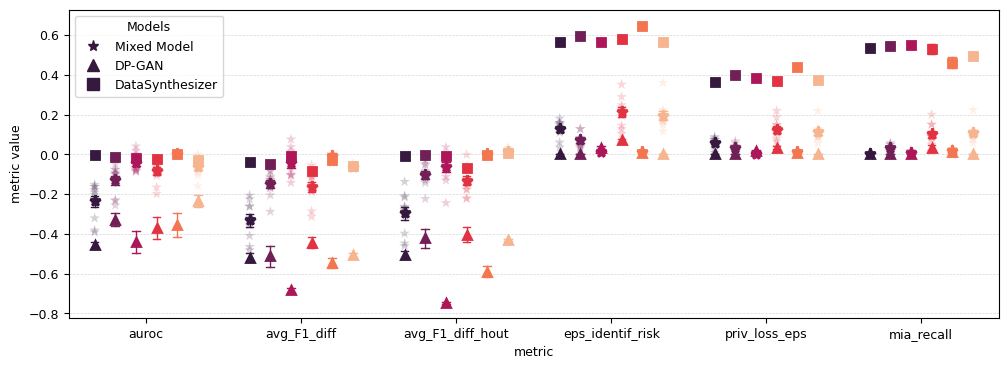

In [2]:
from experiments.auxiliaries.plotting import make_relative_derviation_histogram

datasets = ['al', 'bc', 'cc', 'hd', 'kd', 'st']
make_relative_derviation_histogram(datasets, models=['synthpop', 'dpgan'])

## Comparison of results with strict and adapive validators

Quickly calculate the percentage difference in results and measure z-scores

In [20]:
import numpy as np

from scipy.stats import norm

models_to_check = ['datasynthesizer_ctgan', 'datasynthesizer_adsgan', 'datasynthesizer_dpgan', 'synthpop_ctgan', 'synthpop_adsgan', 'synthpop_dpgan']

for model in models_to_check:
    print(model)
    
    res_adapt = pd.read_csv(f'experiments/results/mixed_model_results/hepatitis_case_study_adapt/{model}.csv', index_col=0)
    res_strict = pd.read_csv(f'experiments/results/mixed_model_results/hepatitis_case_study_strict/{model}.csv', index_col=0)

    # drop the pca rows 
    res_adapt = res_adapt.drop(index=['pca_eigval_diff'])
    res_adapt = res_adapt.drop(index=['pca_eigvec_ang'])

    # calculate percentage difference
    res_diff = (res_strict['mean'] -res_adapt['mean']) / res_adapt['mean'] * 100

    # calculate the z-score for the difference
    z_score = (res_strict['mean'] - res_adapt['mean']) / np.sqrt(res_adapt['sem']**2+res_strict['sem']**2)

    # get p-values
    p_values = 2 * (1 - norm.cdf(np.abs(z_score)))
    p_values = pd.Series(p_values, index=res_adapt.index)

    res = pd.concat([res_adapt['mean'], res_strict['mean'], res_diff, z_score, p_values], axis=1, keys=['adapt', 'strict', 'diff %', 'z_score', 'p_value'])
    print(res)
    

datasynthesizer_ctgan
                     adapt    strict     diff %   z_score   p_value
avg_h_dist        0.012825  0.016411  27.964807  2.520255  0.011727
corr_mat_diff     0.598665  0.685781  14.551717  3.891990  0.000099
auroc             0.031022  0.019819 -36.113688 -1.275894  0.201993
cls_F1_diff       0.023426  0.027228  16.229446  0.899271  0.368509
cls_F1_diff_hout  0.020513  0.030941  50.836434  1.907478  0.056459
eps_identif_risk  0.448869  0.429231  -4.375000 -1.449314  0.147250
priv_loss_eps     0.260000  0.249502  -4.037591 -0.885688  0.375786
median_DCR        0.973517  0.977280   0.386557  0.869725  0.384451
mia_recall        0.262609  0.264348   0.662252  0.109423  0.912867
mia_precision     0.491967  0.514394   4.558636  1.862199  0.062575
datasynthesizer_adsgan
                     adapt    strict     diff %   z_score       p_value
avg_h_dist        0.013285  0.019571  47.313848  4.566601  4.956956e-06
corr_mat_diff     0.599734  0.701595  16.984379  6.796172  1.07